Import stuff

In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import pdb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

%matplotlib notebook
import matplotlib.pyplot as plt

#allow one cell to display multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Define a function to calculate various metrics including precision, recall, accuracy, F1 score, FPR, TPR. These will be used to get an idea of how well the classifier is working, as well as perform ROC analysis.

In [2]:
def calculate_fpr_tpr_f1score_accuracy(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    Tp = 0
    Fp = 0
    Tn = 0
    Fn = 0

    for label, pred in zip(y_true, y_pred):
        if (label == 1) and (pred == 1):
            Tp = Tp+1
        elif (label == 0) and (pred == 1):
            Fp = Fp + 1
        elif (label == 0) and (pred == 0):
            Tn = Tn + 1
        elif (label == 1) and (pred == 0):
            Fn = Fn + 1
        else:
            print('something weird with labels')
            sys.exit()

    #calculate precision, recall, accuracy, f1
    #it's possible for division by zero in some of these cases, so do a try/except
    try: precision = Tp/(Tp + Fp)                           
    except: precision = 0
    
    try: recall = Tp/(Tp + Fn)                              
    except: recall = 0
    
    try: accuracy = (Tn + Tp)/(Tn+Tp+Fn+Fp)                 
    except: accuracy = 0
    
    try: f1Score = 2*precision*recall/(precision + recall)  
    except: f1Score = 0
    
    try: fpr = Fp/(Fp + Tn)                                 
    except: fpr = 0
    
    try: tpr = Tp/(Tp + Fn)                                 
    except: tpr = 0
    
    return (fpr, tpr, f1Score, accuracy)



Define a function to calculate the ROC curve. This is a plot of the false positive rate vs the true positive rate.

In [3]:
def calculate_roc(y_true, prob):
    #calculate the ROC with a probability step size of 0.01
    thresh_delta = 0.01
    thresh_values = [i*thresh_delta for i in range(0,int(1/thresh_delta)+1)]

    stats = []
    for thresh in thresh_values:
        y_pred = (prob > thresh).astype(int)
        fpr, tpr, f1Score, accuracy = calculate_fpr_tpr_f1score_accuracy(y_true, y_pred)
        stats.append([thresh, fpr, tpr, f1Score, accuracy])

    columns = ['thresh', 'fpr', 'tpr', 'f1Score', 'accuracy']
    roc_df = pd.DataFrame(stats, columns=columns)

    return roc_df


Define a function to define and train the model. There are many parameters have been somewhat arbitrarily chosen. To pick the optimal values, each parameter can be tuned via cross validation. 

In [4]:
def train_model(X_train, y_train, test_data, input_dim, class_weights):
    #define model
    model = Sequential()
    model.add(Dense(num_hidden_nodes, activation='relu', input_dim=input_dim))
    model.add(Dense(1, activation='sigmoid'))
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.95, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
    
    #if there's no testing/training data, monitor the loss for determining the stopping point for training
    if test_data is None:
        earlyStopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=min_delta, patience=patience, verbose=verbose, mode=mode)   
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, class_weight=class_weights, callbacks=[earlyStopping], validation_split=0.0, verbose=verbose)
    #otherwise, monitor the validation loss to determine the stopping point for training
    else:
        X_test, y_test = test_data
        earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, verbose=verbose, mode=mode)   
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, class_weight=class_weights, callbacks=[earlyStopping], validation_data=(X_test,y_test), verbose=verbose)

    return model, history


Define a function to train the model in the case where test and training data are present (in other words, this is the training function for cross validation).

In [5]:
def train_model_with_test_data(X_train, y_train, X_test, y_test, do_plot):
    #get the class weights
    class_counts = np.array([np.sum(y_train['label'] == 0), np.sum(y_train['label'] == 1)])
    print('class counts -- off-body: {}, on-body: {}'.format(class_counts[0], class_counts[1]))

    #define the weights as the ratio of the largest class (other)
    class_weights = max(class_counts)/class_counts
    print('class weights -- off-body: {}, on-body: {}'.format(class_weights[0], class_weights[1]))

    #restructure labels for keras
    y_train = np.array([[val] for val in y_train['label']])
    y_test = np.array([[val] for val in y_test['label']])

    #define and train the keras model
    input_dim = np.shape(X_train)[1]
    model, history = train_model(X_train, y_train, (X_test, y_test), input_dim, class_weights)

    #plot the loss over each iteration
    if do_plot:
        fig, ax = plt.subplots(figsize=(8,6))
        p = plt.plot(history.history['loss'], label='train')
        p = plt.plot(history.history['val_loss'], label='validation')
        p = plt.legend(loc='best')
        p = plt.xlabel('SGD iteration number')
        p = plt.ylabel('loss')
        p = plt.show()

    #get the probability for each test example case and calculate the ROC curve
    prob = model.predict(X_test)
    prob = prob.flatten()
    roc_df = calculate_roc(y_test.flatten(), prob)

    return (model, history, roc_df)


Define function to train the model without any training/validation data (in other words, this function is used for training the final model on all the available data).

In [6]:
def train_model_without_test_data(X_train, y_train, do_plot):
    #get the class weights
    class_counts = np.array([np.sum(y_train['label'] == 0), np.sum(y_train['label'] == 1)])
    print('class counts -- off-body: {}, on-body: {}'.format(class_counts[0], class_counts[1]))

    #define the weights as the ratio of the largest class (other)
    class_weights = max(class_counts)/class_counts
    print('class weights -- off-body: {}, on-body: {}'.format(class_weights[0], class_weights[1]))

    #restructure labels for keras
    y_train = np.array([[val] for val in y_train['label']])

    #define and train the keras model
    input_dim = np.shape(X_train)[1]
    model, history = train_model(X_train, y_train, None, input_dim, class_weights)

    #plot the loss over each iteration
    if do_plot:
        fig, ax = plt.subplots(figsize=(8,6))
        p = plt.plot(history.history['loss'], label='train')
        p = plt.legend(loc='best')
        p = plt.xlabel('SGD iteration number')
        p = plt.ylabel('loss')
        p = plt.tight_layout()
        p = plt.show()

    #get the probability for each training example case and calculate the ROC curve
    #the ROC is kind of uneccessary since we're predicting on data that we trained, 
    #but do it anyway beacuse if it's not nearly perfect, something is definitely wrong
    prob = model.predict(X_train)
    prob = prob.flatten()
    roc_df = calculate_roc(y_train.flatten(), prob)

    return (model, history, roc_df)

Define a function to plot the ROC curve. Note that this is an interactive plot where you can click on any point in the average ROC curve and the threshold associated with that coordinate will be displayed over with an arrow. This helps in determing the appropriate threshold for the application.

In [7]:
def plot_roc(roc_df):
    def update_annot(ind):
        x,y = line.get_data()
        annot.xy = (x[ind['ind'][0]], y[ind['ind'][0]])
        text = '{}'.format(' '.join([thresholds[n] for n in ind['ind']]))
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = line.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    #convert "thresholds" to string 
    thresholds = roc_df[0]['thresh']
    thresholds = [('%.3f' % thresh) for thresh in thresholds]
    
    #define the annotation 
    fig, ax = plt.subplots(figsize=(8,6))
    annot = ax.annotate('', xy=(0,0), xytext=(-20,20),textcoords='offset points', bbox=dict(boxstyle='round', fc='w'), arrowprops=dict(arrowstyle='->'))
    annot.set_visible(False)

    #plot all ROC curves 
    #also calculate the average ROC curve
    roc_avg = roc_df[0].copy(deep=True)
    roc_avg[:] = 0
    for ind, df in enumerate(roc_df):
        plt.plot(df['fpr'], df['tpr'], '.-', label=('run %i') % int(ind+1))
        roc_avg = roc_avg + df

    #get the average ROC
    roc_avg = roc_avg/(ind+1)

    #plot average of all ROC curves
    line, = plt.plot(roc_avg['fpr'], roc_avg['tpr'], '*-', label='average ROC')
    plt.legend(loc=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for Multiple Cross Validations')
    fig.canvas.mpl_connect('motion_notify_event', hover)
    plt.tight_layout()
    plt.show()

    return roc_avg


Define various parameters for training the model

In [8]:
num_hidden_nodes = 3
min_delta = 0.01
patience = 0
verbose = 1
mode = 'min'
batch_size = 64
epochs = 50

#define the threshold at which to determine class 0 or class 1. this threshold is chosen based on ROC results
thresh = 0.9

#define number of cross validations to do
num_cross_valids = 5


Load the features and labels, and train via cross validation

class counts -- off-body: 146, on-body: 252
class weights -- off-body: 1.726027397260274, on-body: 1.0
Train on 398 samples, validate on 171 samples
Epoch 1/50
398/398 [==============================] - 0s 377us/step - loss: 0.5660 - binary_accuracy: 0.7915 - val_loss: 0.3986 - val_binary_accuracy: 0.8947
Epoch 2/50
398/398 [==============================] - 0s 21us/step - loss: 0.3230 - binary_accuracy: 0.9397 - val_loss: 0.2261 - val_binary_accuracy: 0.9298
Epoch 3/50
398/398 [==============================] - 0s 20us/step - loss: 0.1839 - binary_accuracy: 0.9472 - val_loss: 0.1649 - val_binary_accuracy: 0.9415
Epoch 4/50
398/398 [==============================] - 0s 18us/step - loss: 0.1238 - binary_accuracy: 0.9573 - val_loss: 0.1548 - val_binary_accuracy: 0.9532
Epoch 5/50
398/398 [==============================] - 0s 17us/step - loss: 0.0925 - binary_accuracy: 0.9648 - val_loss: 0.1577 - val_binary_accuracy: 0.9532
Epoch 00005: early stopping


<IPython.core.display.Javascript object>


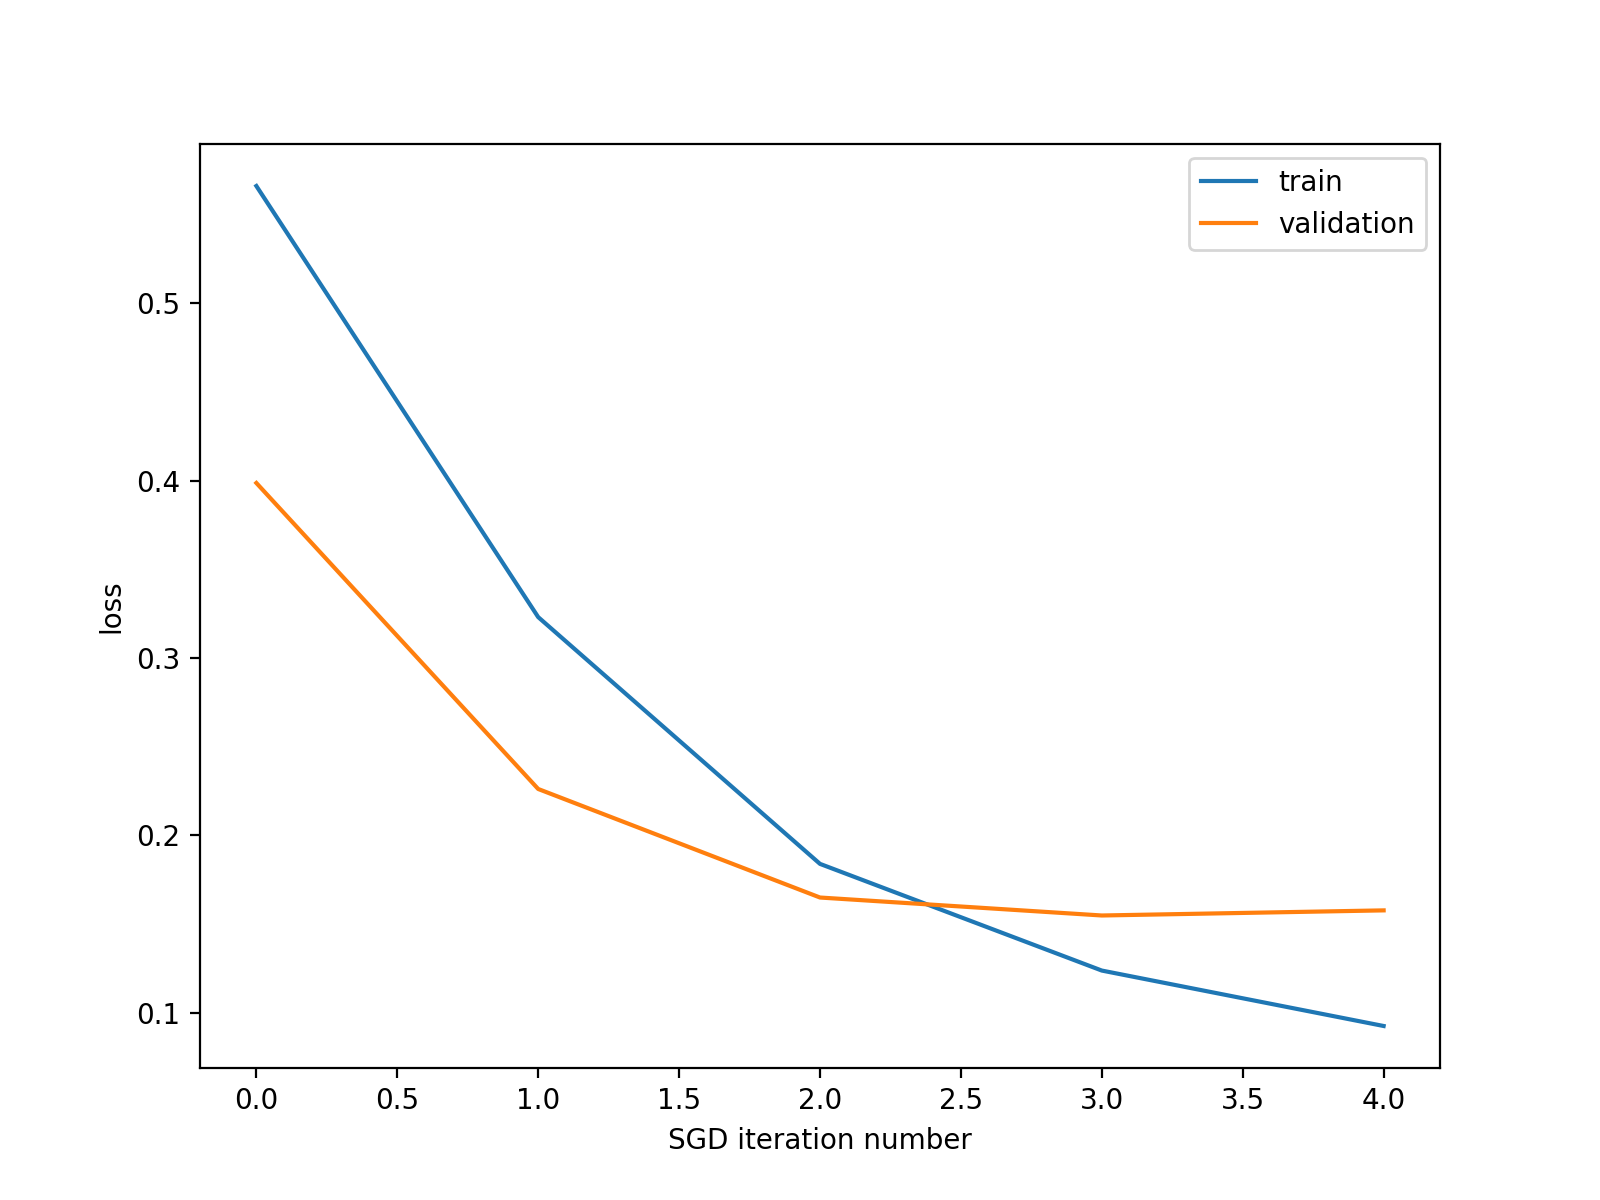

class counts -- off-body: 147, on-body: 251
class weights -- off-body: 1.7074829931972788, on-body: 1.0
Train on 398 samples, validate on 171 samples
Epoch 1/50
398/398 [==============================] - 0s 437us/step - loss: 1.3096 - binary_accuracy: 0.4095 - val_loss: 0.4588 - val_binary_accuracy: 0.9181
Epoch 2/50
398/398 [==============================] - 0s 21us/step - loss: 0.3814 - binary_accuracy: 0.9246 - val_loss: 0.2280 - val_binary_accuracy: 0.9766
Epoch 3/50
398/398 [==============================] - 0s 20us/step - loss: 0.2212 - binary_accuracy: 0.9322 - val_loss: 0.1451 - val_binary_accuracy: 0.9708
Epoch 4/50
398/398 [==============================] - 0s 17us/step - loss: 0.1491 - binary_accuracy: 0.9372 - val_loss: 0.1112 - val_binary_accuracy: 0.9649
Epoch 5/50
398/398 [==============================] - 0s 17us/step - loss: 0.1248 - binary_accuracy: 0.9497 - val_loss: 0.0987 - val_binary_accuracy: 0.9591
Epoch 6/50
398/398 [==============================] - 0s 16us/st

<IPython.core.display.Javascript object>


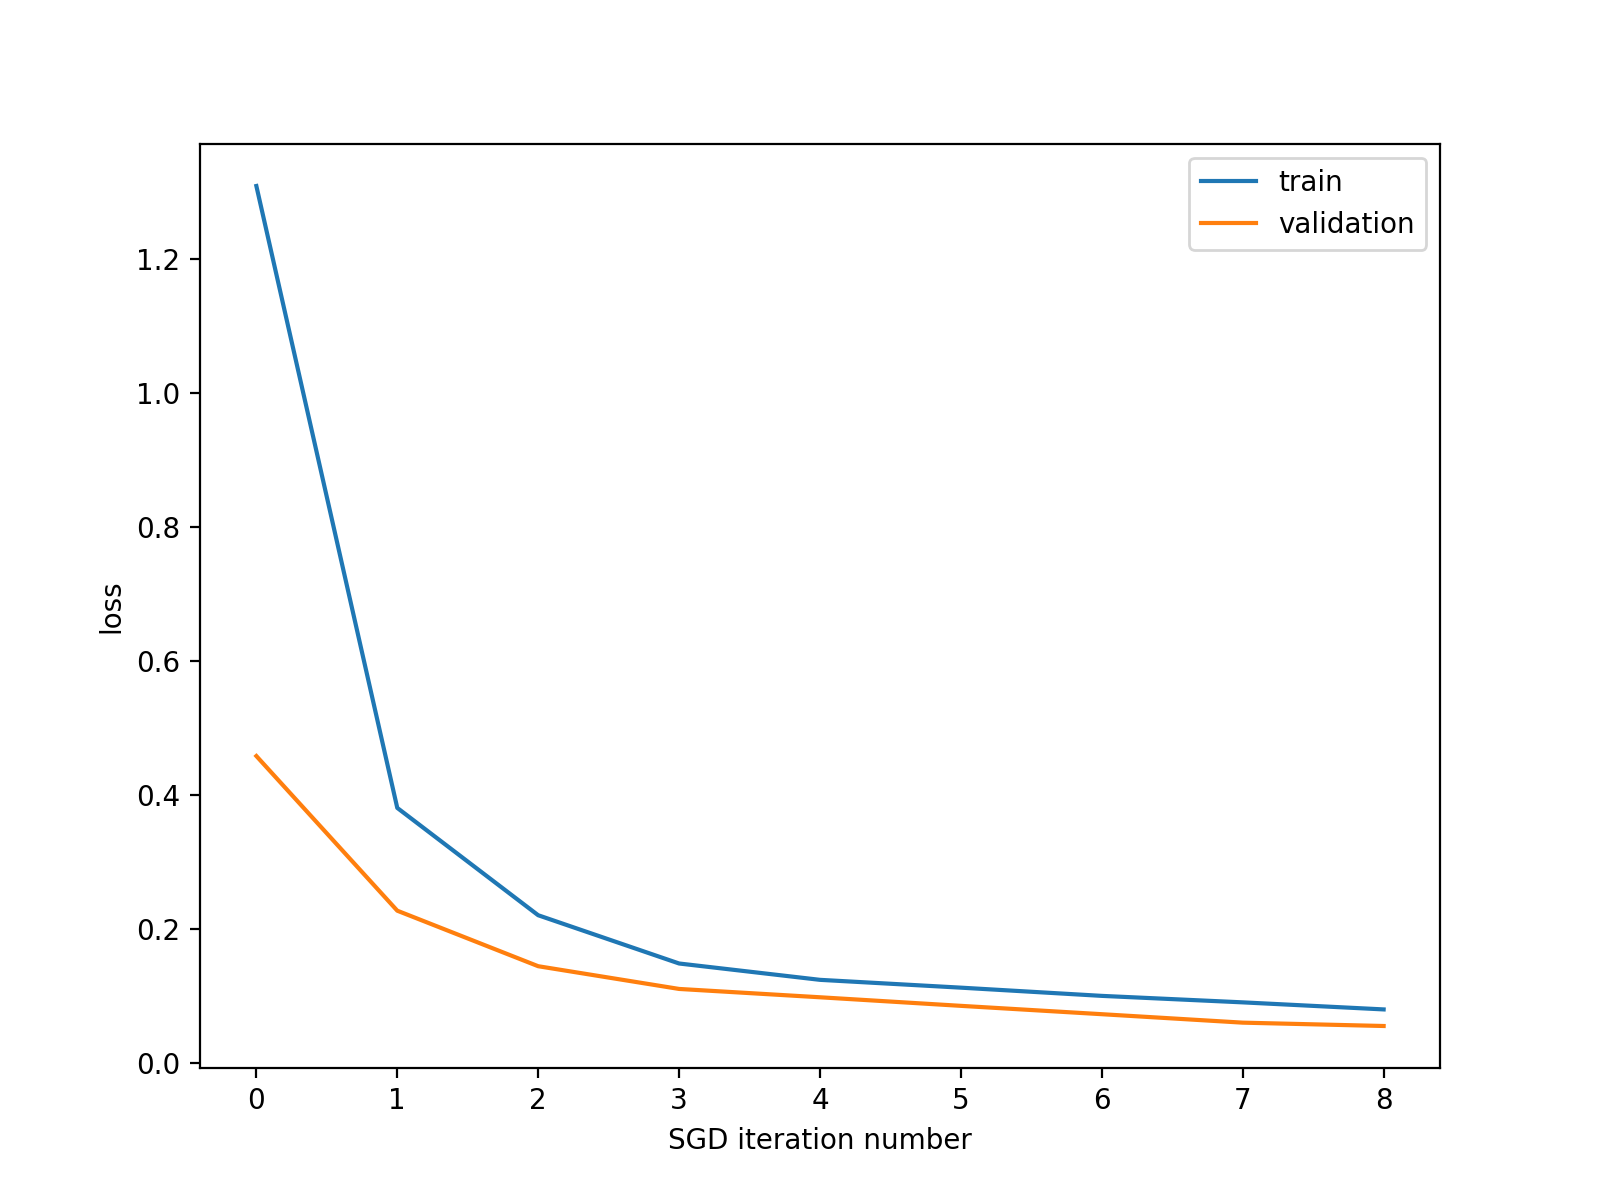

class counts -- off-body: 146, on-body: 252
class weights -- off-body: 1.726027397260274, on-body: 1.0
Train on 398 samples, validate on 171 samples
Epoch 1/50
398/398 [==============================] - 0s 498us/step - loss: 0.6937 - binary_accuracy: 0.5553 - val_loss: 0.4825 - val_binary_accuracy: 0.7661
Epoch 2/50
398/398 [==============================] - 0s 19us/step - loss: 0.4141 - binary_accuracy: 0.8015 - val_loss: 0.2632 - val_binary_accuracy: 0.9123
Epoch 3/50
398/398 [==============================] - 0s 18us/step - loss: 0.2717 - binary_accuracy: 0.9045 - val_loss: 0.1626 - val_binary_accuracy: 0.9474
Epoch 4/50
398/398 [==============================] - 0s 17us/step - loss: 0.1946 - binary_accuracy: 0.9221 - val_loss: 0.1067 - val_binary_accuracy: 0.9649
Epoch 5/50
398/398 [==============================] - 0s 18us/step - loss: 0.1545 - binary_accuracy: 0.9372 - val_loss: 0.0790 - val_binary_accuracy: 0.9708
Epoch 6/50
398/398 [==============================] - 0s 16us/ste

<IPython.core.display.Javascript object>


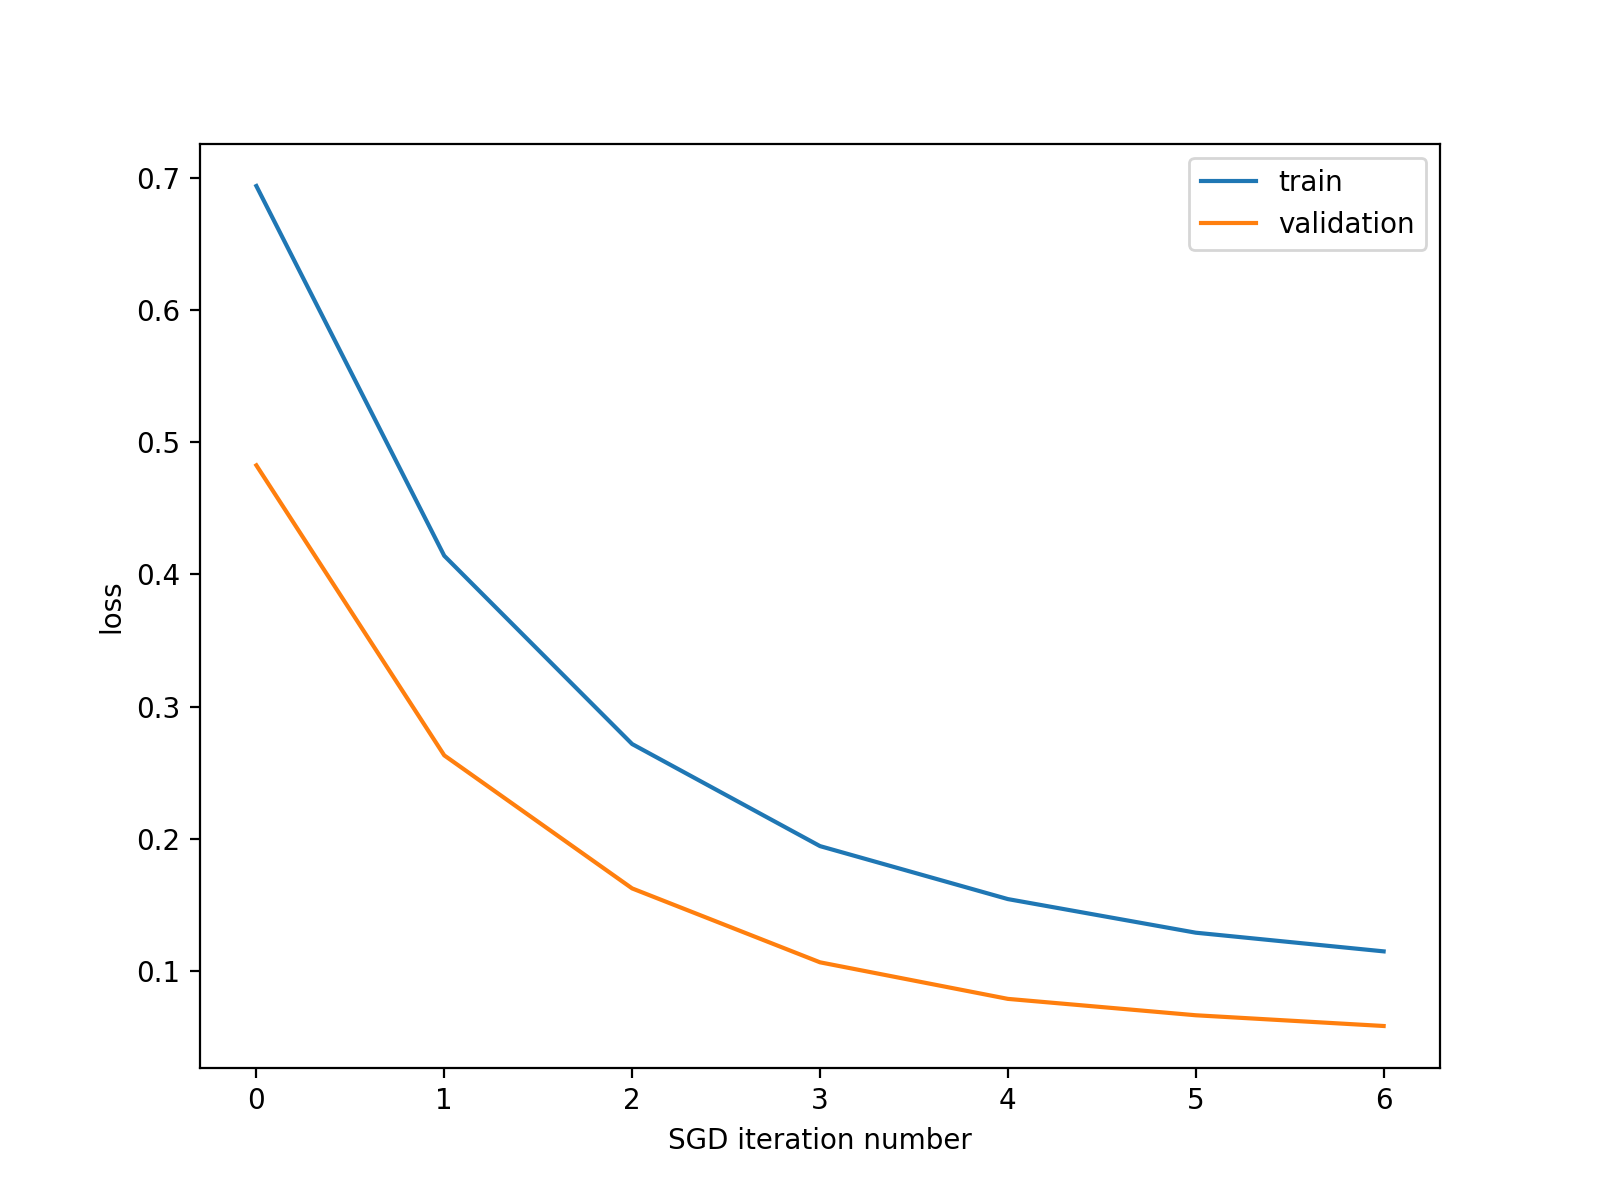

class counts -- off-body: 148, on-body: 250
class weights -- off-body: 1.6891891891891893, on-body: 1.0
Train on 398 samples, validate on 171 samples
Epoch 1/50
398/398 [==============================] - 0s 520us/step - loss: 0.6323 - binary_accuracy: 0.7035 - val_loss: 0.4388 - val_binary_accuracy: 0.8421
Epoch 2/50
398/398 [==============================] - 0s 19us/step - loss: 0.3745 - binary_accuracy: 0.8719 - val_loss: 0.2424 - val_binary_accuracy: 0.9240
Epoch 3/50
398/398 [==============================] - 0s 20us/step - loss: 0.2098 - binary_accuracy: 0.9372 - val_loss: 0.1520 - val_binary_accuracy: 0.9474
Epoch 4/50
398/398 [==============================] - 0s 19us/step - loss: 0.1344 - binary_accuracy: 0.9623 - val_loss: 0.1155 - val_binary_accuracy: 0.9532
Epoch 5/50
398/398 [==============================] - 0s 18us/step - loss: 0.1014 - binary_accuracy: 0.9698 - val_loss: 0.1003 - val_binary_accuracy: 0.9649
Epoch 6/50
398/398 [==============================] - 0s 19us/st

<IPython.core.display.Javascript object>


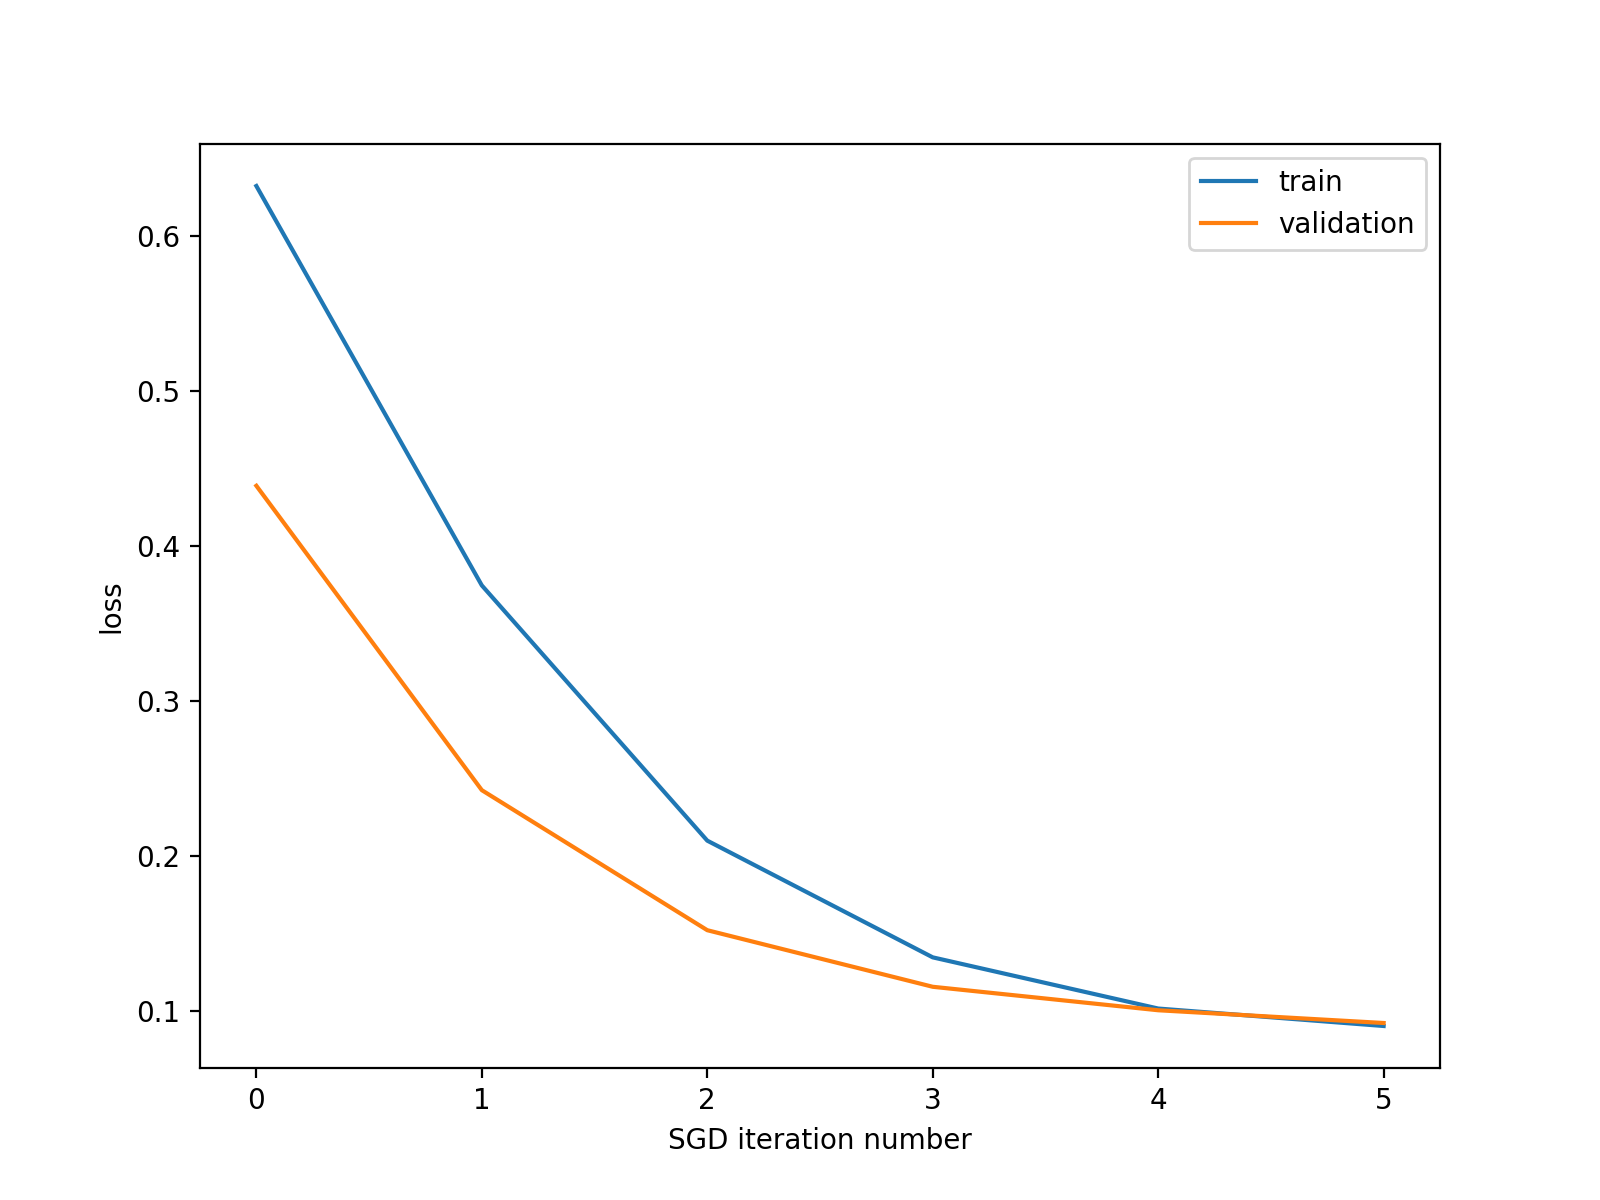

class counts -- off-body: 149, on-body: 249
class weights -- off-body: 1.6711409395973154, on-body: 1.0
Train on 398 samples, validate on 171 samples
Epoch 1/50
398/398 [==============================] - 0s 570us/step - loss: 0.4718 - binary_accuracy: 0.8241 - val_loss: 0.3841 - val_binary_accuracy: 0.9123
Epoch 2/50
398/398 [==============================] - 0s 22us/step - loss: 0.3781 - binary_accuracy: 0.9045 - val_loss: 0.3220 - val_binary_accuracy: 0.9415
Epoch 3/50
398/398 [==============================] - 0s 17us/step - loss: 0.3164 - binary_accuracy: 0.9422 - val_loss: 0.2738 - val_binary_accuracy: 0.9474
Epoch 4/50
398/398 [==============================] - 0s 17us/step - loss: 0.2691 - binary_accuracy: 0.9673 - val_loss: 0.2333 - val_binary_accuracy: 0.9708
Epoch 5/50
398/398 [==============================] - 0s 17us/step - loss: 0.2281 - binary_accuracy: 0.9648 - val_loss: 0.2045 - val_binary_accuracy: 0.9708
Epoch 6/50
398/398 [==============================] - 0s 16us/st

<IPython.core.display.Javascript object>


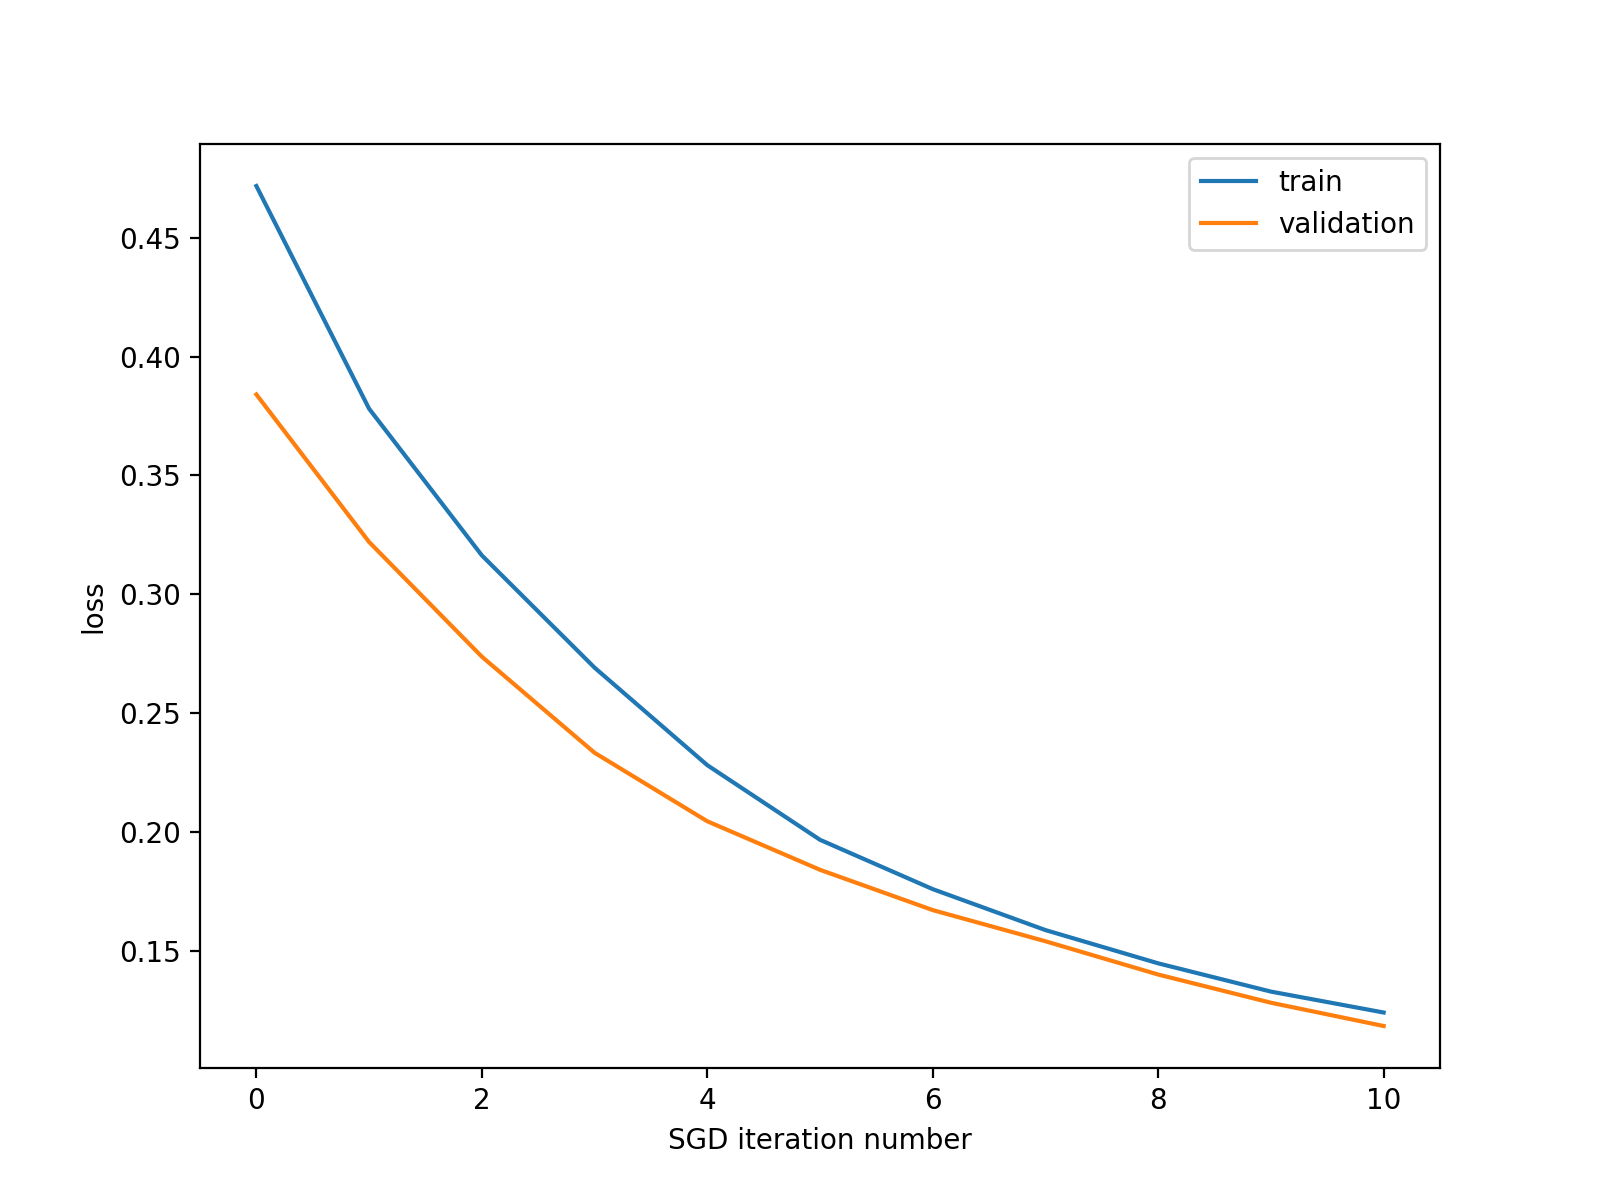

results for cross validation with threshold = 0.900:
   validation_accuracy  traing_loss  validation_loss       fpr       tpr  \
0             0.923977     0.092512         0.157687  0.045455  0.904762   
1             0.941520     0.080612         0.055861  0.015385  0.915094   
2             0.953216     0.114970         0.058534  0.000000  0.923810   
3             0.918129     0.090136         0.092070  0.015625  0.878505   
4             0.912281     0.124033         0.118359  0.000000  0.861111   

    f1Score  threshold  iterations  
0  0.935961        0.9           5  
1  0.950980        0.9           9  
2  0.960396        0.9           7  
3  0.930693        0.9           6  
4  0.925373        0.9          11  
average of all cross validation runs:
validation_accuracy    0.929825
traing_loss            0.100453
validation_loss        0.096502
fpr                    0.015293
tpr                    0.896656
f1Score                0.940681
threshold              0.900000
iterat

<IPython.core.display.Javascript object>


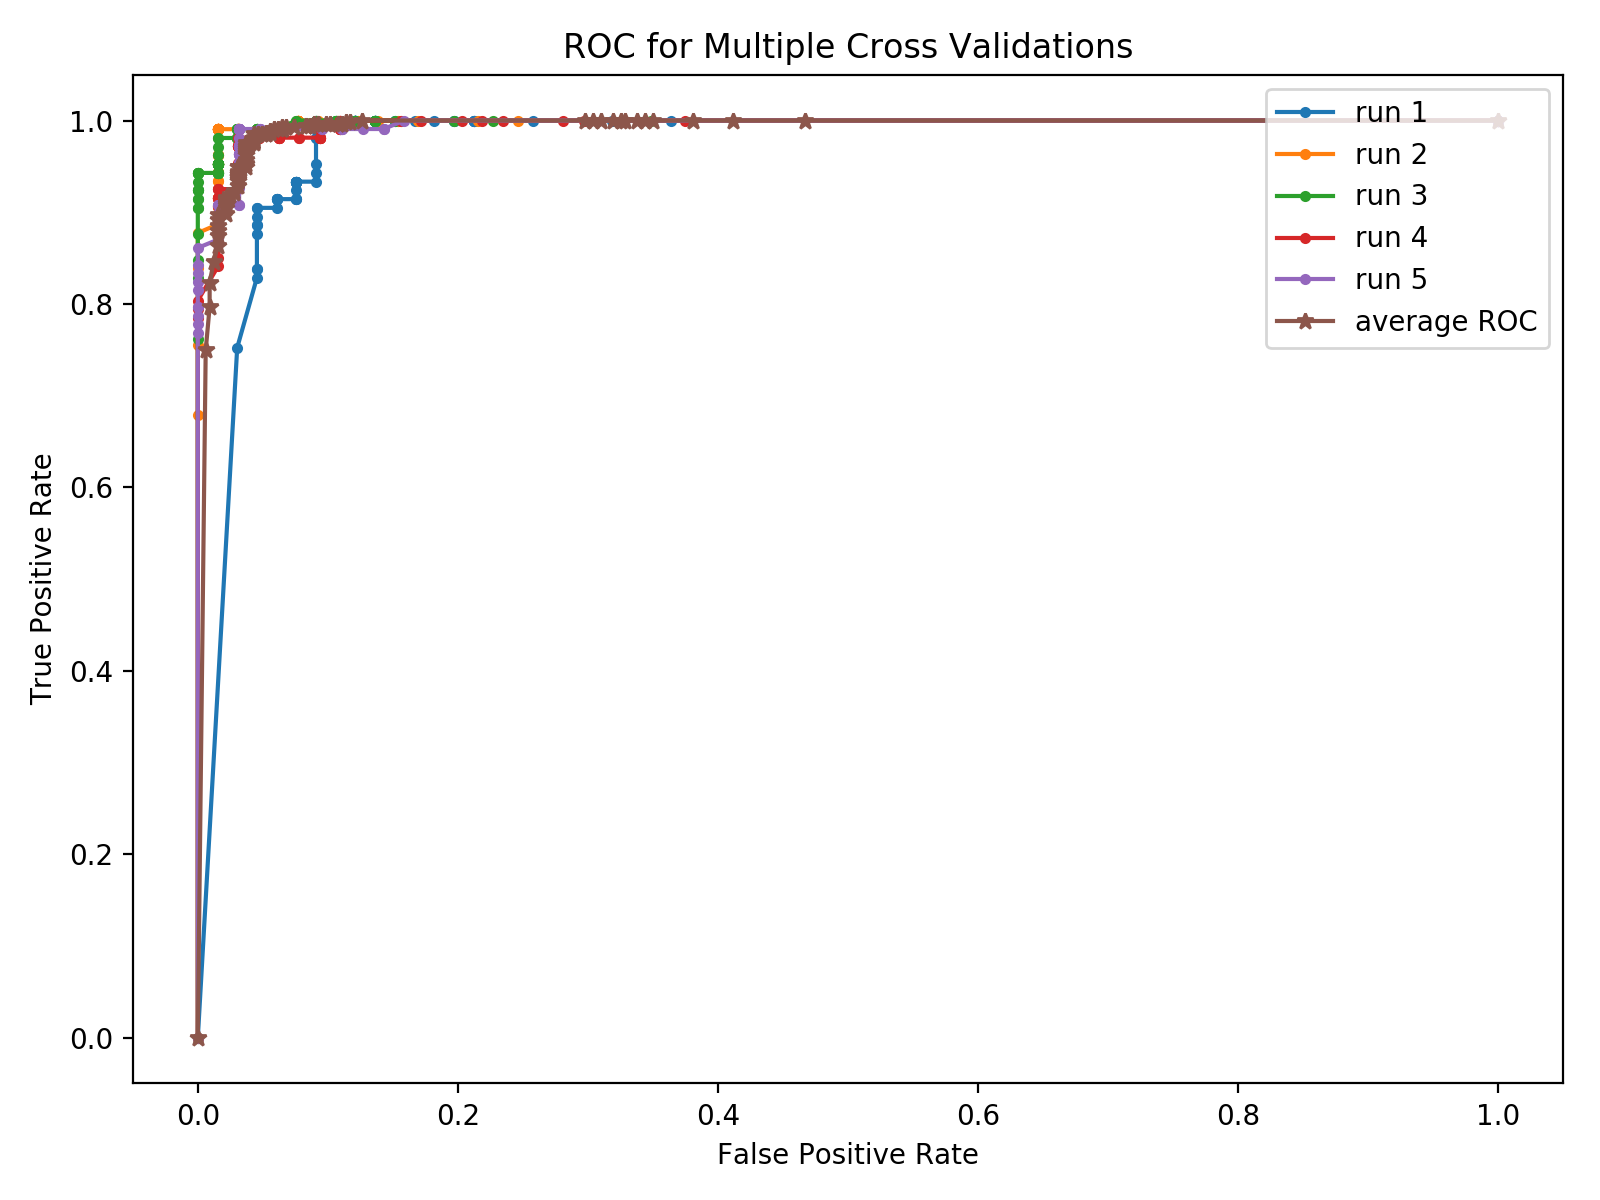

In [9]:
#load training data
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

#results returned from train_model function
columns = ['validation_accuracy', 'traing_loss', 'validation_loss', 'fpr', 'tpr', 'f1Score', 'threshold', 'iterations']

#set up standardscaler
scaler = StandardScaler()

#store the results of each cross validation run
roc_df = []
results = []

#do N-fold cross validation
for i in range(0,num_cross_valids):    
    #separate into 70% train, 30% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    #standardize on training data, then apply the mean and std values to normalize test and train data
    s = scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    #train the keras model and get the results
    model, history, roc_temp = train_model_with_test_data(X_train, y_train, X_test, y_test, do_plot=True)
    roc_df.append(roc_temp)

    #get the results associated with the threshold defined at the top of the code. because of floating point weirdness
    #need to get rid of anything after 3 decimal places via multiplying the threshold by 1000, casting to an int, and
    #then dividing again by 1000
    roc_temp_thresh = roc_temp[(roc_temp['thresh']*1000).astype(int)/1000==thresh]
    results_temp = [roc_temp_thresh['accuracy'].values[0], history.history['loss'][-1], history.history['val_loss'][-1], roc_temp_thresh['fpr'].values[0], roc_temp_thresh['tpr'].values[0], roc_temp_thresh['f1Score'].values[0], thresh, len(history.history['loss'])]
    results.append(results_temp)

#summarize the results
results_df = pd.DataFrame(results, columns=columns)
print('results for cross validation with threshold = %.3f:' % thresh)
print(results_df)
print('average of all cross validation runs:')
print(results_df.mean())

#plot the ROC curves
roc_avg = plot_roc(roc_df)


Now train the model on all the data, both train and validation sets. Export the final model as a file called model.h5

class counts -- off-body: 212, on-body: 357
class weights -- off-body: 1.6839622641509433, on-body: 1.0
Epoch 1/50
569/569 [==============================] - 0s 407us/step - loss: 0.5683 - binary_accuracy: 0.7452
Epoch 2/50
569/569 [==============================] - 0s 16us/step - loss: 0.3403 - binary_accuracy: 0.9139
Epoch 3/50
569/569 [==============================] - 0s 14us/step - loss: 0.2901 - binary_accuracy: 0.9402
Epoch 4/50
569/569 [==============================] - 0s 12us/step - loss: 0.2487 - binary_accuracy: 0.9438
Epoch 5/50
569/569 [==============================] - 0s 11us/step - loss: 0.2128 - binary_accuracy: 0.9490
Epoch 6/50
569/569 [==============================] - 0s 11us/step - loss: 0.1848 - binary_accuracy: 0.9543
Epoch 7/50
569/569 [==============================] - 0s 12us/step - loss: 0.1607 - binary_accuracy: 0.9596
Epoch 8/50
569/569 [==============================] - 0s 12us/step - loss: 0.1421 - binary_accuracy: 0.9666
Epoch 9/50
569/569 [===========

<IPython.core.display.Javascript object>


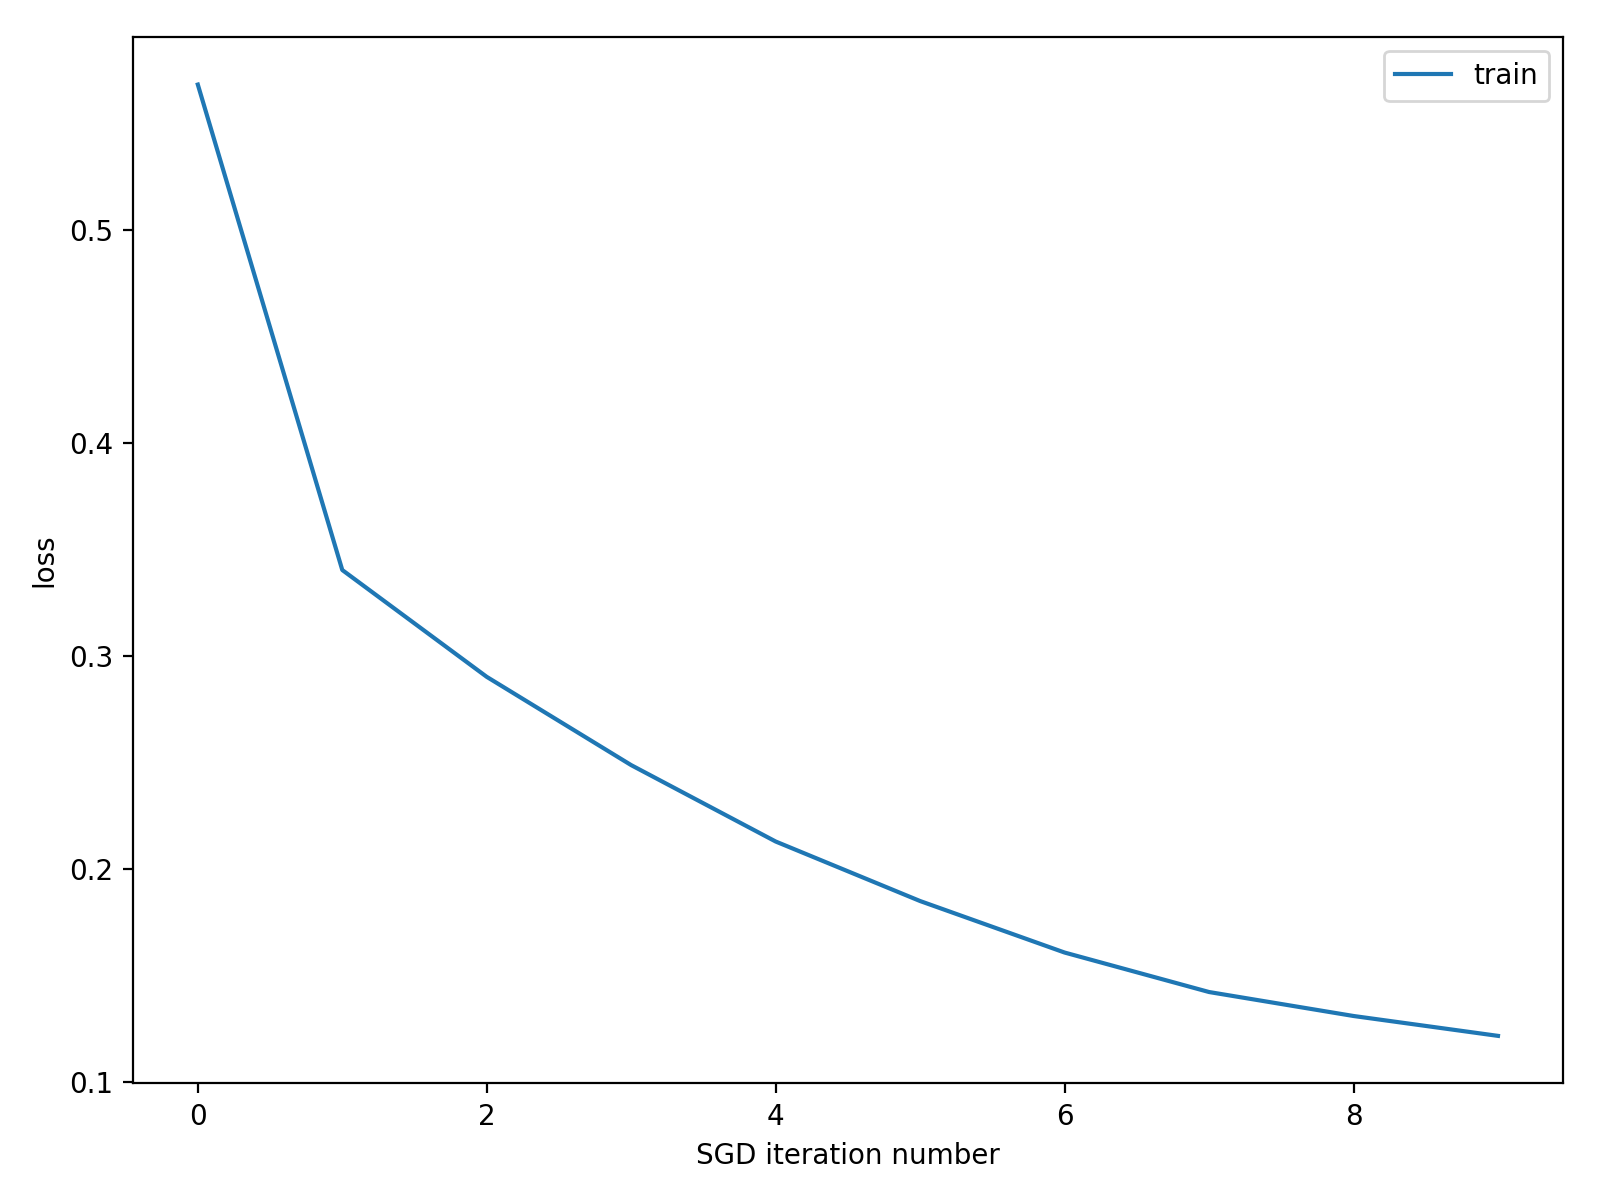

In [10]:
#load the data again because it's been scaled
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

#standardize 
scaler = StandardScaler()
s = scaler.fit(X)
X = scaler.transform(X)

#train the keras model and get the results
model, history, roc_temp = train_model_without_test_data(X, y, do_plot=True)

#save the scaler object for classification later
with open('standard_scaler.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

#save the threshold
with open('thresh.pickle', 'wb') as handle:
    pickle.dump(thresh, handle, protocol=pickle.HIGHEST_PROTOCOL)

#save the model to a file
model.save('model.h5')  
